# f GAN

* f-GAN Tensorflow f-GAN: Training Generative Neural Samplers Using Variational Divergence Minimization
* Ref
  * LynnHo님 : https://github.com/LynnHo/f-GAN-Tensorflow
  * 이일구 님 : https://github.com/ilguyi/tensorflow.tutorials/blob/master/tf.version.2/05.generative_models/01.dcgan.ipynb

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import sys
import time
import glob
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import PIL
import imageio
from IPython import display


import tensorflow as tf
from tensorflow.keras import layers
tf.enable_eager_execution()

tf.logging.set_verbosity(tf.logging.INFO)

print(tf.__version__)

1.13.1


In [0]:
# set hpyer-parameters
batch_size = 256
lr_G = 5e-5
lr_D = 2e-5

max_epochs = 50
save_epochs = 10
print_steps = 100

num_examples_to_generate = 16
noise_dim = 100

In [0]:
(train_data, train_labels), (test_data, test_labels) = \
    tf.keras.datasets.mnist.load_data()

In [4]:
# setting a dataset
(train_data, train_labels), (test_data, test_labels) = \
    tf.keras.datasets.mnist.load_data()

train_data = train_data / 255.
train_data = train_data.reshape([-1, 28, 28, 1])
train_data = train_data.astype(np.float32)
train_labels = train_labels.astype(np.int32)

tf.set_random_seed(219) # by 219!!

# for train
train_dataset = tf.data.Dataset.from_tensor_slices(train_data)
train_dataset = train_dataset.shuffle(buffer_size = 60000)
train_dataset = train_dataset.batch(batch_size = batch_size)
print(train_dataset)

<DatasetV1Adapter shapes: (?, 28, 28, 1), types: tf.float32>


## get_divergence_funcs

In [0]:
def get_divergence_funcs(divergence):
    if divergence == 'Kullback-Leibler':
        def activation_fn(v): return v

        def conjugate_fn(t): return tf.exp(t - 1)

    elif divergence == 'Reverse-KL':
        def activation_fn(v): return -tf.exp(-v)

        def conjugate_fn(t): return -1 - tf.log(-t)

    elif divergence == 'Pearson-X2':
        def activation_fn(v): return v

        def conjugate_fn(t): return 0.25 * t * t + t

    elif divergence == 'Squared-Hellinger':
        def activation_fn(v): return 1 - tf.exp(-v)

        def conjugate_fn(t): return t / (1 - t)

    elif divergence == 'Jensen-Shannon':
        def activation_fn(v): return tf.log(2.0) - tf.log(1 + tf.exp(-v))

        def conjugate_fn(t): return -tf.log(2 - tf.exp(t))

    elif divergence == 'GAN':
        def activation_fn(v): return -tf.log(1 + tf.exp(-v))

        def conjugate_fn(t): return -tf.log(1 - tf.exp(t))

    return activation_fn, conjugate_fn

In [0]:
# set a divergence function
divergence = 'Reverse-KL'
activation_fn, conjugate_fn = get_divergence_funcs(divergence)

# ?? tricky G
tricky_G = True

## Set models

In [0]:
class G(tf.keras.Model):
  def __init__(self):
    super(G, self).__init__()
    self.conv1 = layers.Conv2DTranspose(filters=256, kernel_size=(3, 3), 
                                        strides=(2, 2), use_bias=False)
    self.conv1_bn = layers.BatchNormalization()
    self.conv2 = layers.Conv2DTranspose(filters=128, kernel_size=(3, 3),
                                        strides=(2, 2), use_bias=False)
    self.conv2_bn = layers.BatchNormalization()
    self.conv3 = layers.Conv2DTranspose(filters=64, kernel_size=(4, 4),
                                        strides=(2, 2), padding='same', use_bias=False)
    self.conv3_bn = layers.BatchNormalization()
    self.conv4 = layers.Conv2DTranspose(filters=1, kernel_size=(4, 4),
                                        strides=(2, 2), padding='same')
    
  def call(self, inputs, training=True):
    conv1 = self.conv1(inputs)
    conv1_bn = self.conv1_bn(conv1, training=training)
    conv1 = tf.nn.relu(conv1_bn)
    
    conv2 = self.conv2(conv1)
    conv2_bn = self.conv2_bn(conv2, training=training)
    conv2 = tf.nn.relu(conv2_bn)
    
    conv3 = self.conv3(conv2)
    conv3_bn = self.conv3_bn(conv3, training=training)
    conv3 = tf.nn.relu(conv3_bn)
    
    conv4 = self.conv4(conv3)
    generated_data = tf.nn.sigmoid(conv4)
    
    return generated_data

In [0]:
class D(tf.keras.Model):
  def __init__(self):
    super(D, self).__init__()
    self.conv1 = layers.Conv2D(64, (4, 4), strides=(2, 2), padding='same')
    self.conv2 = layers.Conv2D(128, (4, 4), strides=(2, 2), padding='same', 
                               use_bias=False)
    self.conv2_bn = layers.BatchNormalization()
    self.conv3 = layers.Conv2D(256, (3, 3), strides=(2, 2), use_bias=False)
    self.conv3_bn = layers.BatchNormalization()
    self.conv4 = layers.Conv2D(1, (3, 3))

    
  def call(self, inputs, training=True):
    conv1 = tf.nn.leaky_relu(self.conv1(inputs))
    conv2 = self.conv2(conv1)
    conv2_bn = self.conv2_bn(conv2, training=training)
    conv3 = self.conv3(conv2_bn)
    conv3_bn = self.conv3_bn(conv3, training=training)
    conv4 = self.conv4(conv3_bn)
    discriminator_logits = tf.squeeze(conv4, axis=[1, 2])
    
    return discriminator_logits

In [0]:
generator = G()
discriminator = D()

## set loss and opti

In [0]:
def loss_GAN(logits, is_real=True):
  if is_real:
    labels = -tf.reduce_mean(activation_fn(logits)) # r_output
  else:
    labels = tf.reduce_mean(conjugate_fn(activation_fn(logits))) # f_output

  return labels

In [0]:
def loss_D(real_logits, fake_logits):
  real_loss = loss_GAN(logits=real_logits, is_real=True)
  fake_loss = loss_GAN(logits=fake_logits, is_real=False)
  
  total_loss = real_loss + fake_loss
  
  return total_loss

In [0]:
def loss_G(fake_logits):
  if tricky_G:
    return loss_GAN(logits=fake_logits, is_real=True)
  else:
    return loss_GAN(logits=fake_logits, is_real=False) * (-1)

In [0]:
discriminator_optimizer = tf.train.AdamOptimizer(lr_D, beta1=0.5)
generator_optimizer = tf.train.AdamOptimizer(lr_G, beta1=0.5)

## ckpt


In [0]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Training

In [0]:
random_vector_for_generation = tf.random_normal([num_examples_to_generate, 1, 1, noise_dim])

In [0]:
def generate_and_save_images(model, epoch, test_input):
  # make sure the training parameter is set to False because we
  # don't want to train the batchnorm layer when doing inference.
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))
  
  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0], cmap='gray')
      plt.axis('off')
        
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [0]:
def print_sample_data(sample_data, max_print=num_examples_to_generate):
  print_images = sample_data[:max_print,:]
  print_images = print_images.reshape([max_print, 28, 28])
  print_images = print_images.swapaxes(0, 1)
  print_images = print_images.reshape([28, max_print * 28])
  
  plt.figure(figsize=(max_print, 1))
  plt.axis('off')
  plt.imshow(print_images, cmap='gray')
  plt.show()

Epochs: 50.13 global_step: 11750 loss_D: -6.827 loss_G: 1404.406 (2197.17 examples/sec; 0.117 sec/batch)


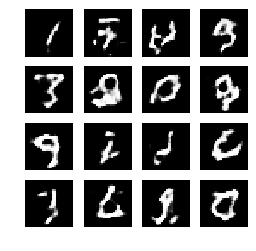

In [18]:
tf.logging.info('Start Session.')
#global_step = tf.train.get_or_create_global_step()
step = 0
for epoch in range(max_epochs):

  for images in train_dataset:
    start_time = time.time()
    
    # generating noise from a uniform distribution
    noise = tf.random_normal([batch_size, 1, 1, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_logits = discriminator(images, training=True)
      fake_logits = discriminator(generated_images, training=True)

      gen_loss = loss_G(fake_logits)
      disc_loss = loss_D(real_logits, fake_logits)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, 
                                                    discriminator.variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, 
                                            generator.variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, 
                                                discriminator.variables))
    
    epochs = step * batch_size / float(len(train_data))
    duration = time.time() - start_time
    step += 1

    if step % print_steps == 0:
      display.clear_output(wait=True)
      examples_per_sec = batch_size / float(duration)
      print("Epochs: {:.2f} global_step: {} loss_D: {:.3f} loss_G: {:.3f} ({:.2f} examples/sec; {:.3f} sec/batch)".format(
                epochs, step, disc_loss, gen_loss, examples_per_sec, duration))
      sample_data = generator(random_vector_for_generation, training=False)
      print_sample_data(sample_data.numpy())
    
  if epoch % 1 == 0:
    display.clear_output(wait=True)
    examples_per_sec = batch_size / float(duration)
    print("Epochs: {:.2f} global_step: {} loss_D: {:.3f} loss_G: {:.3f} ({:.2f} examples/sec; {:.3f} sec/batch)".format(
                epochs, step, disc_loss, gen_loss, examples_per_sec, duration))
    generate_and_save_images(generator,
                             epoch + 1,
                             random_vector_for_generation)

  # saving (checkpoint) the model every save_epochs
  if (epoch + 1) % save_epochs == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)

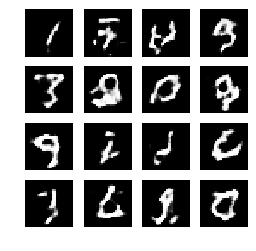

In [19]:
# generating after the final epoch
display.clear_output(wait=True)
generate_and_save_images(generator,
                         max_epochs,
                         random_vector_for_generation)

## Restore Ckpy and show imgs

In [20]:
with imageio.get_writer('dcgan.gif', mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)
    
# this is a hack to display the gif inside the notebook
os.system('cp dcgan.gif dcgan.gif.png')

0

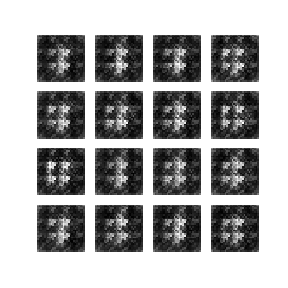

In [21]:
display.Image(filename="dcgan.gif.png")